In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'
import numpy as np
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import jax
import jax.random

import optax

In [2]:
def NN (x, parameters):
    """Standard Multy-Layer-Perceptron"""
    num_layers = len(parameters["biases"])
    for i, (w, b) in enumerate(zip(parameters["weights"],parameters["biases"])):
        x = jnp.matmul(w,x) + b
        if i < num_layers - 1: # apply the nonlinearity on internal layers  
            x = jnp.tanh(x)
    return x

In [3]:
key = jax.random.key( 57 )
subkey, key = jax.random.split(key)

print(jax.random.normal(subkey, [10] ))

[-0.66177326 -0.85960454 -1.7466114  -2.0252008   0.6359112   1.1914747
  0.76947963  0.80131793  1.0185106   0.6452166 ]


In [4]:
def NN_init_params(key, num_neurons_layers):
    """
    Given a jax random key and a list of the neuron numbers
    in the layers of a network (simple fully connected network,
    i.e. 'multi-layer perceptron'), return a dictionary
    with the weights initialized randomly and biases set to zero.
    
    Returns: params, with params['weights'] a list of matrices and
    params['biases'] a list of vectors.
    """
    params = {}
    params["weights"] = []
    params["biases"] = []
    for in_layer, out_layer in zip(num_neurons_layers[:-1], num_neurons_layers[1:]):
        subkey, key = jax.random.split(key)
        # We divide each layer by a factor 1/√(num_outputs), this is a standard practice
        params["weights"].append( (jax.random.normal(subkey, [out_layer, in_layer]))/ jnp.sqrt(out_layer))
        params["biases"].append(jax.random.normal(subkey, [out_layer]))
    return params
    


We want to plot the output of this network for various values of the input. Ideally, we do **not** want to run a for loop over all possible input values, which would be slow.

Here in_axes is telling vmap that we want a batch dimension for the first argument (the vector x), and that this new batch dimension is the dimension 0. 

On the other hand, the second argument of the network would be params, and we do not want those to have a batch dimension - otherwise every sample in the batch would be processed using different weights and biases. This is indicated by the None. 

The out_axes just indicates where the batch dimension is in the output, and we choose it also as 0.

In [5]:
NN_batch = vmap( NN, in_axes = [0,None], out_axes = 0)

In [6]:
# create a sweep in x, but convert the shape to [100,1]
# where 100 is the batchsize and '1' is the original input dimension
# required for the network:
batchsize = 100
x = jnp.linspace( -3.0, +3.0, batchsize )[:,None]

plt.plot( x[:,0], NN_batch( x, params ) )
plt.show()

NameError: name 'params' is not defined

In [11]:
# batch-averaged mean-square-error deviation between x and y_target:
def mse_loss_batch(x, y_target, params):
    return jnp.sum( ( NN_batch(x,params) - y_target )**2 ) / jnp.shape(x)[0]

In [12]:
# take gradient with respect to params (argument number '2' out of 0,1,2)
# also return value of loss:
mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=2)
mse_loss_batch_val_grad = jax.jit( mse_loss_batch_val_grad  )

In [13]:
# Target function:
# our "true" function that we want to fit using the neural network:
def F(q):
    return jnp.exp( - q**2 ) * jnp.cos( 2*q ) * q**2 * jnp.sinh(q+0.3)

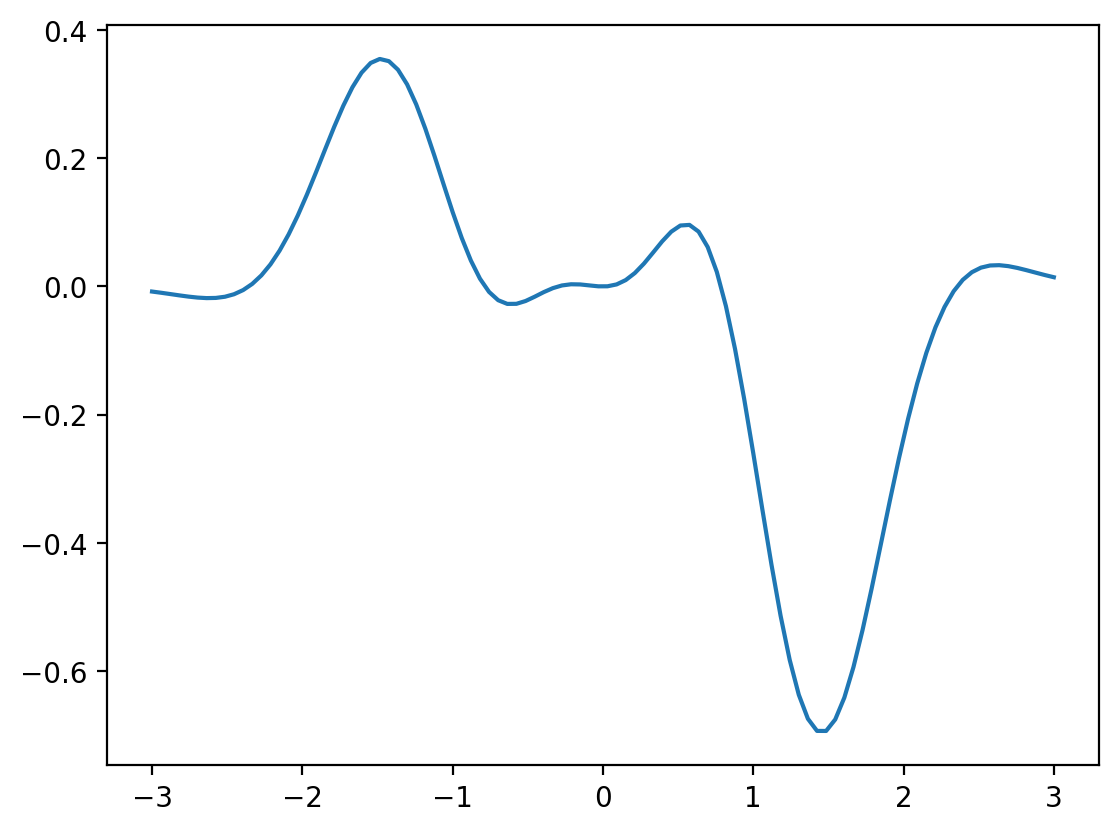

In [14]:
x = jnp.linspace(-3,3,100)
plt.plot(x, F(x))
plt.show()

In [15]:
# Network params
 
num_hidden1 = 20
num_hidden2 = 30
params = NN_init_params(subkey, [1,num_hidden1,num_hidden2,1])

subkey, key = jax.random.split(key)
NN(jax.random.normal(subkey, [1]),params)

learning_rate = 1e-2

# get the optimizer:
optimizer = optax.adam( learning_rate )
# initialize the 'state' of the optimizer, by
# telling it about the initial values:
opt_state = optimizer.init( params )

In [16]:
# training parameters
num_training_batches = 100
batchsize = 32
x_range = [-3.0, 3.0]
losses=[]

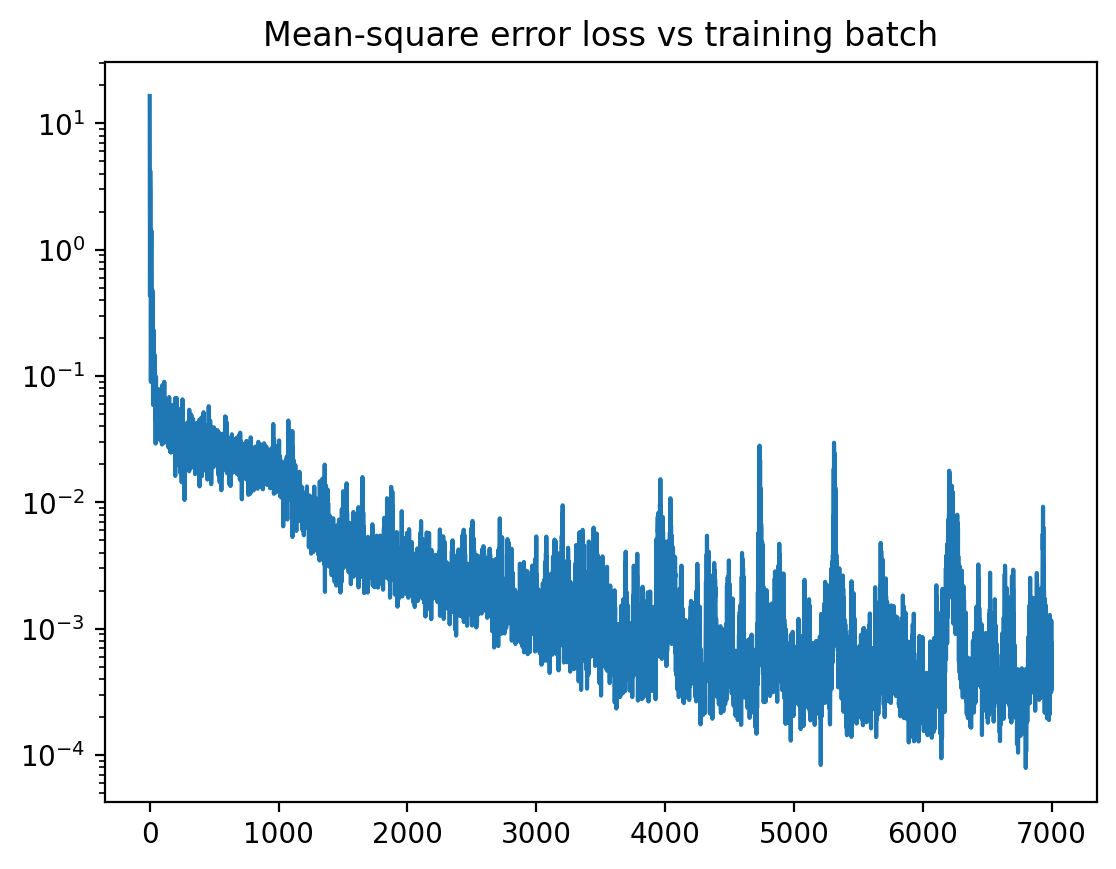

In [29]:
# run this cell multiple times to continue training!
for _ in range(10):    
    for idx_batch in range(num_training_batches):
        # get training batch, by evaluating F at
        # random locations:
        subkey,key = jax.random.split( key )
        x = jax.random.uniform( subkey, [batchsize, 1], minval = x_range[0], maxval = x_range[1])
        y_target = F( x ) # the true values
        
        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad( x, y_target, params )

        # update the network parameters:
        updates, opt_state = optimizer.update( grads, opt_state )
        params = optax.apply_updates( params, updates )

        # add the loss to the list:
        losses.append(loss)

plt.plot( losses )
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.show()

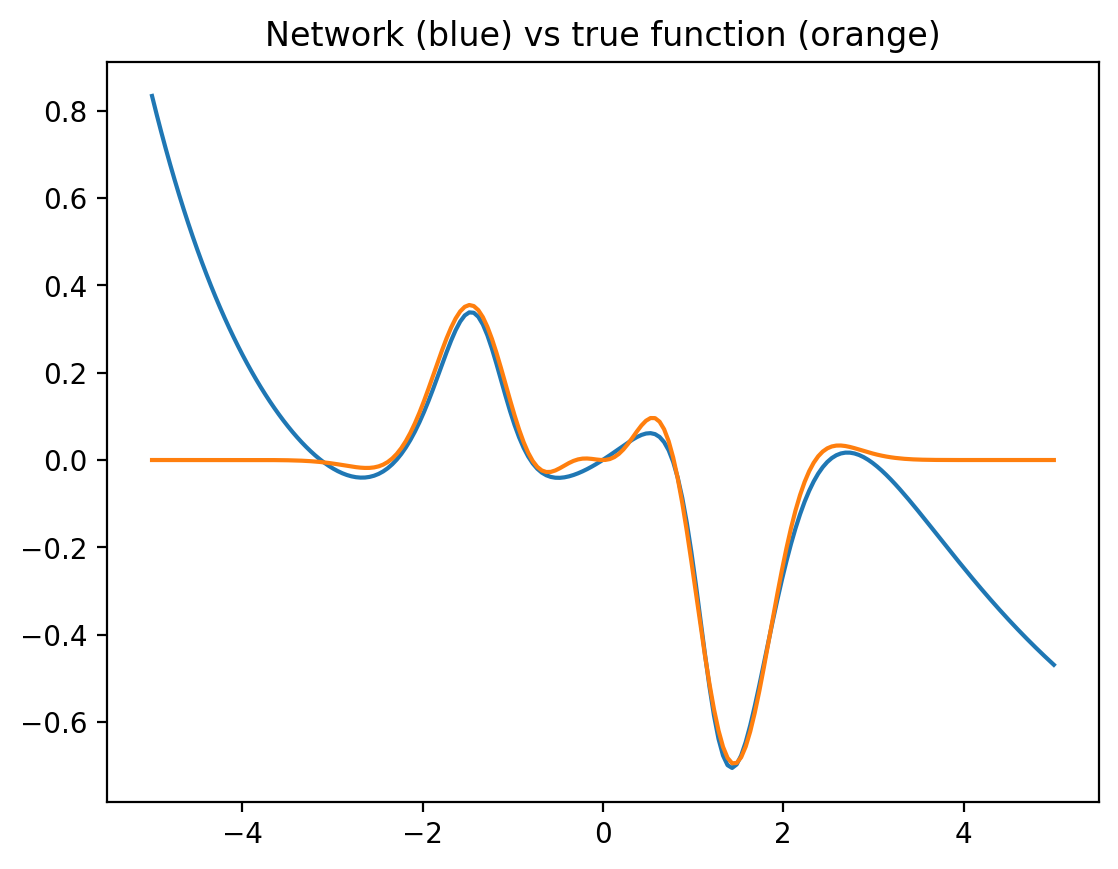

In [30]:
x = jnp.linspace( -5.0, 5.0, 200 )[:,None]
net_output = NN_batch( x, params )

plt.plot( x, net_output )
plt.plot( x, F( x ))
plt.title("Network (blue) vs true function (orange)")
plt.show()